# Anomaly Detection with GANs for Multivariate Time Series
https://arxiv.org/pdf/1809.04758.pdf

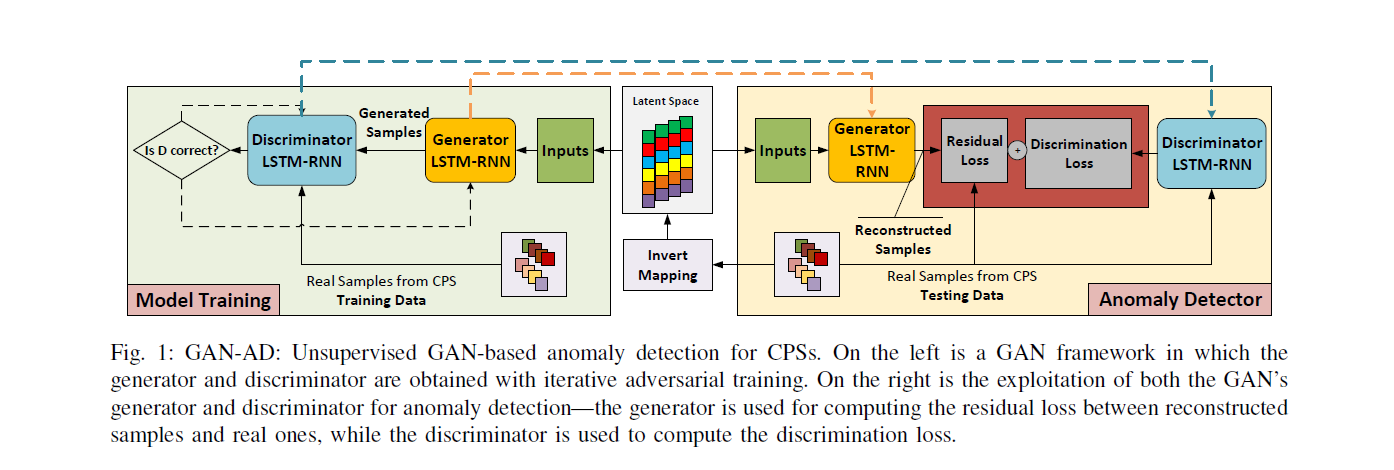

In [3]:
import os
import pandas as pd
from time_series_anomaly_detection.detector import GAN_AD
import random
from datetime import date
import matplotlib.pyplot as plt

# Skoltech Anomaly Benchmark (SKAB) dataset
https://github.com/waico/SKAB

## Load and split data

In [4]:
# single multivariate time series
df_anomaly_free = pd.read_csv("../datasets/skab/anomaly-free/anomaly-free.csv", index_col='datetime', sep=';',parse_dates=True).reset_index(drop=True)

In [5]:
ratio = 0.75
split = int(len(df_anomaly_free)*ratio)
df_anomaly_free, df_with_anomalies = df_anomaly_free.iloc[:split,:].reset_index(drop=True), df_anomaly_free.iloc[split:,:].reset_index(drop=True)

In [6]:
df_anomaly_free.describe()

,Accelerometer1RMS,Accelerometer2RMS,Current,Pressure,Temperature,Thermocouple,Voltage,Volume Flow RateRMS
count,7050.000000,7050.000000,7050.000000,7050.000000,7050.000000,7050.000000,7050.000000,7050.000000
mean,0.211477,0.269542,2.532384,0.111784,89.700982,28.138902,228.435041,124.765474
std,0.004761,0.004007,5.341825,0.253411,0.648544,0.672366,12.242058,1.731301
min,0.198511,0.260767,0.855284,-0.929070,88.546100,26.765800,1.336380,118.000000
25%,0.209461,0.266371,2.129020,0.054711,89.213800,27.600425,222.478000,123.335000
50%,0.212496,0.268205,2.545025,0.054711,89.579700,28.271000,228.886000,125.331000
75%,0.214572,0.273093,2.731903,0.382638,90.152500,28.702025,234.830250,126.000000
max,0.222114,0.280214,230.819000,1.366420,91.724900,29.075200,252.806000,128.351000


In [7]:
# insert dummy fake anomalies
random.seed(10)
anomaly_index = random.sample(range(0, df_with_anomalies.shape[0]), int(0.2*df_with_anomalies.shape[0]))
df_with_anomalies.iloc[anomaly_index, [0,1,4]] = df_with_anomalies.iloc[anomaly_index, [0,1,4]] * 0.95
df_with_anomalies.iloc[anomaly_index, [2,6]] = df_with_anomalies.iloc[anomaly_index, [2,6]] * 1.1
df_with_anomalies.describe()

,Accelerometer1RMS,Accelerometer2RMS,Current,Pressure,Temperature,Thermocouple,Voltage,Volume Flow RateRMS
count,2351.000000,2351.000000,2351.000000,2351.000000,2351.000000,2351.000000,2351.000000,2351.000000
mean,0.212532,0.262935,2.732348,0.110365,88.035954,29.252970,233.227498,126.266731
std,0.005716,0.006057,8.191684,0.250134,1.792206,0.099487,16.602414,0.707121
min,0.184866,0.246094,0.863201,-1.257000,83.773280,29.063000,1.036640,123.000000
25%,0.209564,0.262062,2.167385,0.054711,88.447550,29.166900,224.940500,126.000000
50%,0.213241,0.264525,2.570990,0.054711,88.791400,29.252400,230.968000,126.325000
75%,0.216960,0.266243,2.780435,0.382638,89.093300,29.343700,242.561500,126.678000
max,0.225967,0.276206,255.230800,0.710565,89.755700,29.522100,277.720300,128.353000


In [8]:
df_anomalies_labels = df_with_anomalies.copy()
df_anomalies_labels['label'] = 0
df_anomalies_labels.iloc[anomaly_index, :] = 1
df_anomalies_labels = df_anomalies_labels.drop(columns=['Accelerometer1RMS','Accelerometer2RMS','Current','Pressure','Temperature','Thermocouple','Voltage','Volume Flow RateRMS'])

## Model's parameters settings

In [9]:
# values selected based on experiments
window_size = 16
shift = 5
batch_size = 32
latent_dim = 2 
n_features = df_anomaly_free.shape[1]

## Training

In [10]:
gan_ad = GAN_AD(window_size, shift, batch_size, latent_dim, n_features)
gan_ad.fit(df_anomaly_free, 10000, save_checkpoints=True, enable_prints=True)
# gan_ad.save_model("gan_ad_" + str(date.today()) + ".h5")

KeyboardInterrupt: 

7000 . epoch
Batch loss (disc_loss, gen_loss) : [0.21547717 3.9397886 ]

7500 . epoch
Batch loss (disc_loss, gen_loss) : [0.05491132 4.837315  ]

8000 . epoch
Batch loss (disc_loss, gen_loss) : [0.34914508 3.4787216 ]

8500 . epoch
Batch loss (disc_loss, gen_loss) : [0.80346507 2.6210155 ]

9000 . epoch
Batch loss (disc_loss, gen_loss) : [0.2298915 3.904429 ]

In [11]:
gan_ad.load_weights("gan_ad_2021-05-01_epoch_9000.h5")
gan_ad.fit_scaler(df_anomaly_free)

In [12]:
# less than one window
anomaly_scores = gan_ad.predict_anomaly_scores(pd.DataFrame(df_anomaly_free[0:0+window_size-5]))

Not enough data to predict anomaly scores.


In [1]:
# X = pd.DataFrame(df_anomaly_free[0:0+3+window_size*2])
# windows = [pd.DataFrame(df_anomaly_free[i:i+window_size]) for i in range(0,X.shape[0]-(X.shape[0]%window_size),window_size)]

In [2]:
# windows

Ignoring last 8 samples (incomplete window).
loss celkovo:  0.37826478696378996
loss celkovo:  0.055566342260641555
loss celkovo:  0.055565528961149545
loss celkovo:  0.055564820315307538
loss celkovo:  0.055564179633473591
final loss:  0.058761567448775892
[[-0.340188205 -1.17083836]
 [-0.487221509 1.55881858]
 [0.983184934 0.631233454]
 ...
 [0.290670604 0.250190049]
 [0.889208853 -1.28376615]
 [-1.99823701 -0.620838642]]
sample


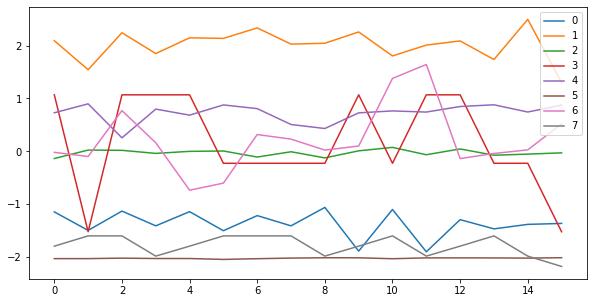

generated_sample


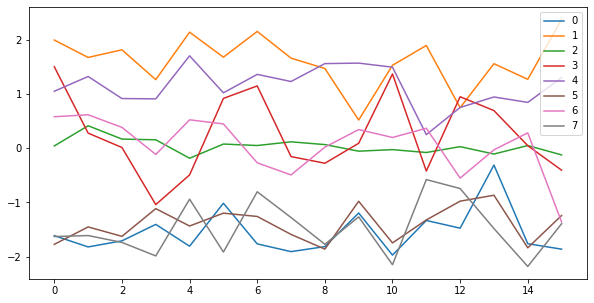

residuals: 
tf.Tensor(
[2.50864349 4.35860058 3.79357375 4.19511611 6.13870897 4.50306314
 4.96346033 3.25305407 3.06414198 6.11292557 5.58457573 6.05385526
 4.26436463 3.62166805 2.71045326 6.63640761], shape=(16,), dtype=float64)
real_prob
tf.Tensor([0.80653393], shape=(1,), dtype=float32)
loss celkovo:  0.20811291285305863
loss celkovo:  0.12560507136648352
loss celkovo:  0.11692269577307439
loss celkovo:  0.072104563966611
loss celkovo:  0.07043926285788718
final loss:  0.0746241853870473
[[-1.0219779 0.00186482817]
 [-1.44154084 -1.22244143]
 [-0.570074201 -0.439001322]
 ...
 [2.52866387 1.23146009]
 [-2.11367273 0.475731134]
 [-6.0259428 -3.79916167]]
sample


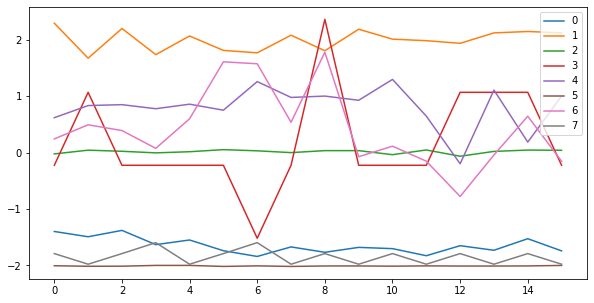

generated_sample


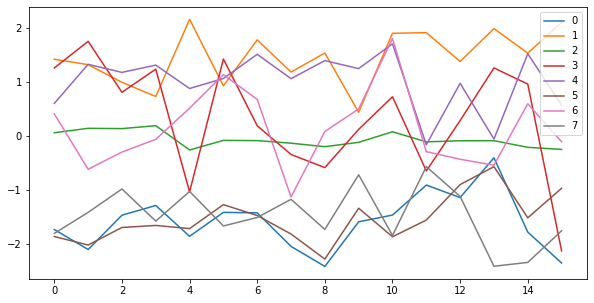

residuals: 
tf.Tensor(
[3.11450468 3.91066882 4.57945529 4.03135995 2.82705576 4.64740837
 4.01411312 4.28843776 6.53550696 5.15290752 3.69840848 4.39179156
 5.17774977 5.31233577 3.67441523 4.56663252], shape=(16,), dtype=float64)
real_prob
tf.Tensor([0.7172581], shape=(1,), dtype=float32)
anomaly_scores
0     1.351055
1     2.276033
2     1.993520
3     2.194291
4     3.166088
5     2.348265
6     2.578463
7     1.723260
8     1.628804
9     3.153196
10    2.889021
11    3.123661
12    2.228915
13    1.907567
14    1.451960
15    3.414937
16    1.698623
17    2.096705
18    2.431099
19    2.157051
20    1.554899
21    2.465075
22    2.148428
23    2.285590
24    3.409124
25    2.717825
26    1.990575
27    2.337267
28    2.730246
29    2.797539
30    1.978579
31    2.424687
dtype: float64


In [13]:
# more than one window
anomaly_scores = gan_ad.predict_anomaly_scores(pd.DataFrame(df_anomaly_free[0:0+(2*window_size)+8]))
print('anomaly_scores')
print(anomaly_scores)

Window with anomalies


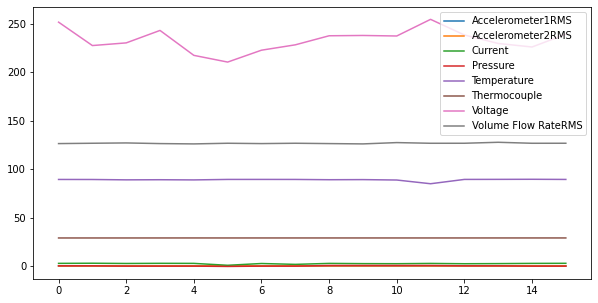

Window with anomalies - true labels


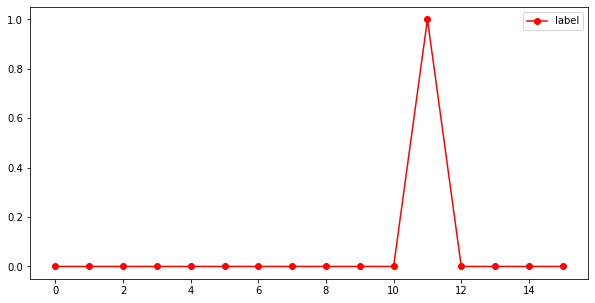

loss celkovo:  0.14030330795991236
loss celkovo:  0.12032884620681507
loss celkovo:  0.11942303040078728
loss celkovo:  0.11942284395891412
loss celkovo:  0.11942266644441533
final loss:  0.11946321495931836
[[-0.830295503 1.10307097]
 [0.582897425 0.212375671]
 [0.225840598 -2.33999658]
 ...
 [-3.96347404 0.840678394]
 [-9.66038704 0.735214889]
 [9.35611 2.32337618]]
sample


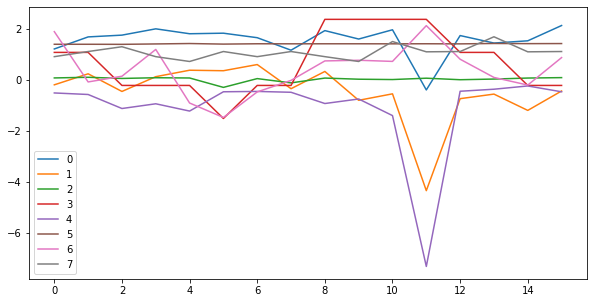

generated_sample


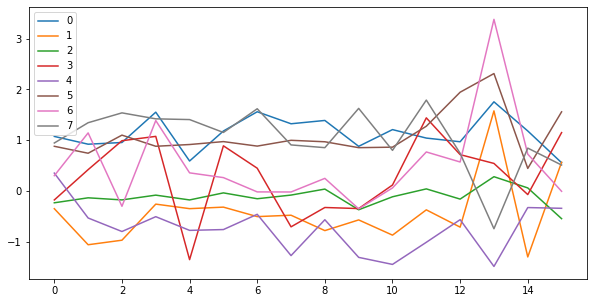

residuals: 
tf.Tensor(
[ 4.82894891  5.08743649  4.04092759  3.95489998  6.21879566  6.48195884
  3.75360817  2.21086261  5.69261104  7.18328065  5.36444709 14.84046532
  2.5498226  10.97500858  2.83003593  6.31692185], shape=(16,), dtype=float64)
real_prob
tf.Tensor([0.57753885], shape=(1,), dtype=float32)
cross_entropy
0     0.965349
1     1.013399
2     0.802761
3     0.783299
4     1.200154
5     1.239015
6     0.736223
7     0.275100
8     1.117609
9     1.335756
10    1.062451
11    2.032280
12    0.396183
13    1.740244
14    0.486276
15    1.214821
dtype: float64
Window with anomalies - resulted labels


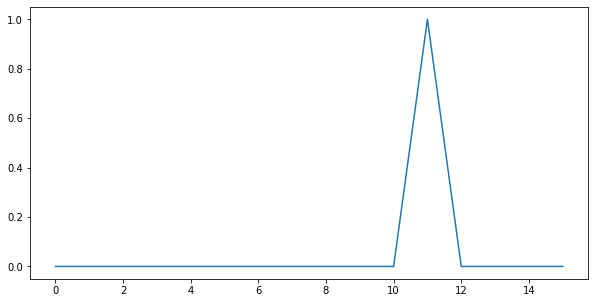

In [15]:
# one window
print('Window with anomalies')
window = pd.DataFrame(df_with_anomalies[i:i+window_size])
window.plot(figsize=(10,5))
plt.show()

print('Window with anomalies - true labels')
window = pd.DataFrame(df_anomalies_labels[i:i+window_size])
window.plot(color='red', marker='o', figsize=(10,5))
plt.show()

anomaly = gan_ad.identify_anomaly(pd.DataFrame(df_with_anomalies[i:i+window_size]), treshold = 2)
print('Window with anomalies - resulted labels')
anomaly.plot(figsize=(10,5))
plt.show()

Data with anomalies


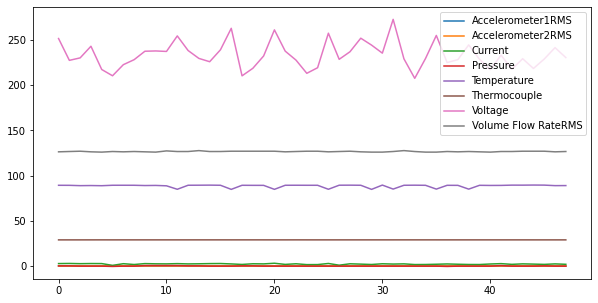

Data with anomalies - true labels


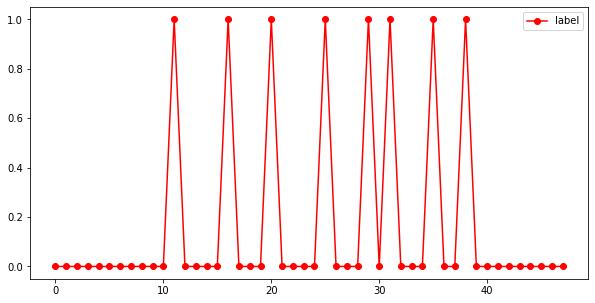

loss celkovo:  0.1439549966247276
loss celkovo:  0.12301201927494024
loss celkovo:  0.12301189091459147
loss celkovo:  0.12301175834230649
loss celkovo:  0.12301162729544818
final loss:  0.12120623606721648
[[-1.43512666 0.605916321]
 [-0.0583721399 1.01428056]
 [0.747235775 0.672405303]
 ...
 [-1.82490778 2.03367472]
 [-3.52974343 1.82084131]
 [-2.40052795 0.572221518]]
sample


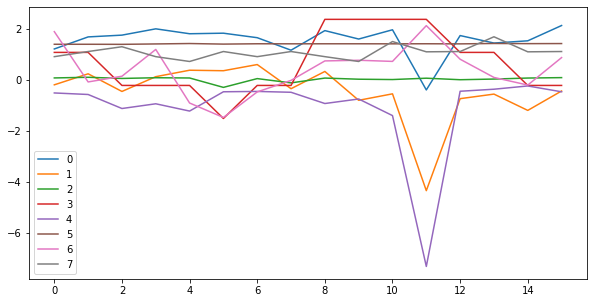

generated_sample


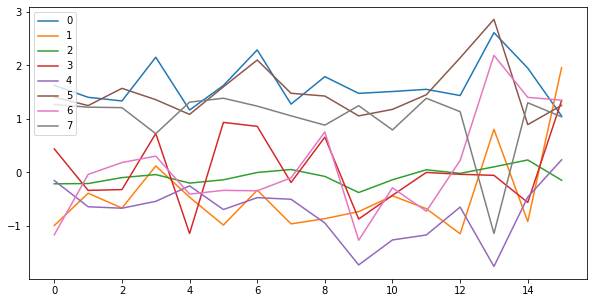

residuals: 
tf.Tensor(
[ 5.93605346  2.97068641  1.63518758  2.73460283  5.07031647  6.00403799
  3.88097871  1.15110041  3.23951239  7.71153439  5.5687551  17.3226351
  3.36813537 11.5064395   3.7744989   6.68267273], shape=(16,), dtype=float64)
real_prob
tf.Tensor([0.6945584], shape=(1,), dtype=float32)
loss celkovo:  0.26918913428006808
loss celkovo:  0.24044518303253887
loss celkovo:  0.2382490298112914
loss celkovo:  0.23555476340009449
loss celkovo:  0.23539031048002948
final loss:  0.23711686106710345
[[-0.414349854 -0.26236251]
 [-0.692031562 0.272895694]
 [0.292630911 0.293250352]
 ...
 [-1.45096374 2.64281392]
 [7.58182764 -0.646688581]
 [-3.36809087 0.857379317]]
sample


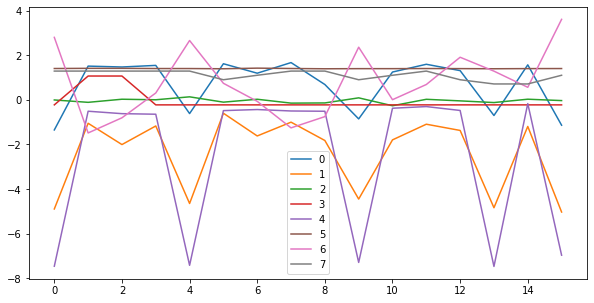

generated_sample


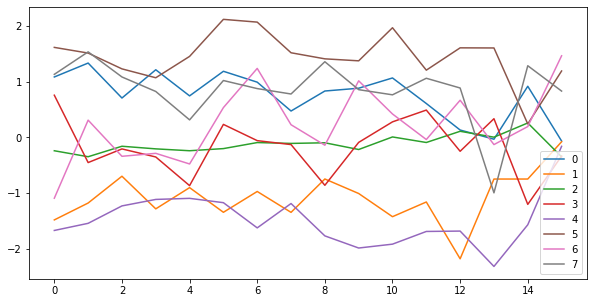

residuals: 
tf.Tensor(
[17.12743159  5.2329159   4.99946144  2.63049172 16.61937466  3.47206161
  4.50938897  4.47477031  3.8564251  12.34925427  4.19411722  4.41888513
  4.83237706 13.94688274  5.80608962 15.88953737], shape=(16,), dtype=float64)
real_prob
tf.Tensor([0.6195867], shape=(1,), dtype=float32)
loss celkovo:  0.18569302153619427
loss celkovo:  0.13782027078611492
loss celkovo:  0.13781943910420794
loss celkovo:  0.13781866065564113
loss celkovo:  0.13781791680040303
final loss:  0.13776065227848522
[[-1.98891103 0.55162853]
 [1.90241706 -1.35202384]
 [-0.499748 0.346093029]
 ...
 [-1.32403111 -1.27579784]
 [0.0439614356 3.08586025]
 [-2.02848554 1.38351846]]
sample


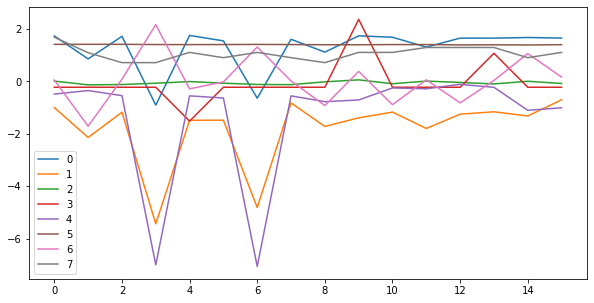

generated_sample


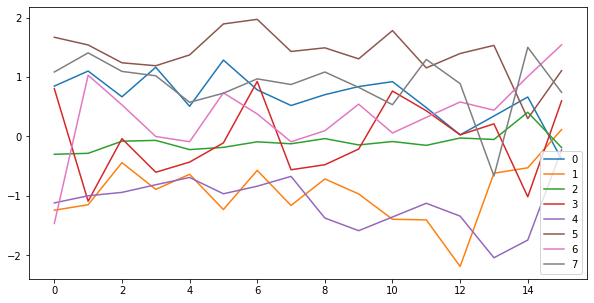

residuals: 
tf.Tensor(
[ 5.46393469  6.08496172  3.41560216 15.86277149  4.27711916  2.48884164
 14.695341    2.03292976  3.7696087   5.49774156  4.97538564  3.38706146
  5.86063323  7.0681496   5.36641402  6.59573419], shape=(16,), dtype=float64)
real_prob
tf.Tensor([0.73747987], shape=(1,), dtype=float32)
cross_entropy
0     1.138073
1     0.493515
2    -0.030135
3     0.418725
4     0.988752
5     1.148906
6     0.738699
7    -0.317082
8     0.572378
9     1.388414
10    1.077422
11    2.176346
12    0.608019
13    1.775959
14    0.712935
15    1.251064
16    2.169502
17    1.031997
18    0.989518
19    0.409094
20    2.140054
21    0.655569
22    0.894005
23    0.886900
24    0.750670
25    1.850788
26    0.827357
27    0.875323
28    0.957968
29    1.969019
30    1.129223
31    2.096173
32    1.051949
33    1.154911
34    0.609255
35    2.087242
36    0.819700
37    0.318949
38    2.012090
39    0.137782
40    0.701147
41    1.057836
42    0.962775
43    0.601465
44    1.118930
45

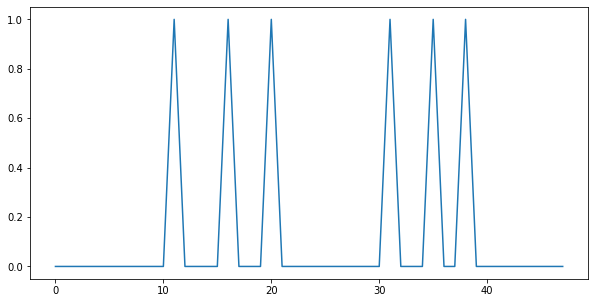

In [16]:
# more than one window
print('Data with anomalies')
window = pd.DataFrame(df_with_anomalies[i:i+window_size*3])
window.plot(figsize=(10,5))
plt.show()

print('Data with anomalies - true labels')
window = pd.DataFrame(df_anomalies_labels[i:i+window_size*3])
window.plot(color='red', marker='o', figsize=(10,5))
plt.show()

anomaly = gan_ad.identify_anomaly(pd.DataFrame(df_with_anomalies[i:i+window_size*3]), treshold = 2)
print('Data with anomalies - resulted labels')
anomaly.plot(figsize=(10,5))
plt.show()